In [1]:
from scipy.io import wavfile
from scipy import signal as ss
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from yin_detection import *
%load_ext line_profiler

In [3]:
def optimized_calculaitons(f, W, t, sample_rate, bounds, th=0.1, p_energy=0, p_freq=1):
    energy_array = np.array(f[t:t+W+bounds[1]+1]*f[t:t+W+bounds[1]+1], dtype=float).cumsum()
    energy_2_array = (energy_array[W:W+bounds[1]+1]-energy_array[:bounds[1]+1]).cumsum()
    #autocorrelation = np.array([np.sum(f[t: t+W] * f[t+i:i+t+W]) for i in range(bounds[1]+1)])
    correlation = ss.correlate(f[t: t+W], f[t: t+W+bounds[1]], mode='full', method='fft')
    autocorrelation = correlation[:-W][::-1][:bounds[1]+1]
    autocorr_sum = autocorrelation[1:].cumsum()
    
    def calc_df(lag):
        return energy_array[W] + (energy_array[W+lag] - energy_array[lag-1]) - 2 * autocorrelation[lag] 
    
    def calc_dmndf(lag):
        if lag == 0:
            return 1
        return calc_df(lag) / (lag * energy_array[W] + energy_2_array[lag] - 2 * autocorr_sum[lag] + 1e-10) * lag# np.sum([calc_df(i) for i in range(1,lag)]) * lag 
    
    curr_energy = energy_array[-1]/(W+bounds[1]+1)**2
    speach = True
    if p_energy > 0:
        if curr_energy < p_energy*0.3:
            speach = False
            curr_energy = p_energy
            return 1, [], curr_energy
        elif p_freq < 2:
            return p_freq+1, [], curr_energy
    
    CMNDF_vals = np.array([calc_dmndf(i) for i in range(*bounds)])
    sample = None
    posible_sample = None
    if p_freq > 50:
        p_sample = sample_rate/p_freq- bounds[0]
        if p_sample > 0:
            posible_sample = np.argmin(CMNDF_vals[int(p_sample*0.7):int(p_sample*1.3)])+int(p_sample*0.7)
            if CMNDF_vals[posible_sample] < 0.3:
                sample = posible_sample +  bounds[0]
                
    if CMNDF_vals[0] < 0.55:
        sample = sample_rate
        
    if sample is None:
        r = np.where(CMNDF_vals<=th)[0]
        if r.size > 1:
            p = np.where(r[:-1] != (r[1:]-1))[0]
            last = -1 if p.size < 1 else p[0]
            sample = np.argmin(CMNDF_vals[r[0]:r[last]]) + r[0] + bounds[0]
        if r.size == 1:
            sample = r[0] + bounds[0]
            
    if sample is None:
        if p_freq > 50:
            posible = np.argmin(CMNDF_vals)+bounds[0]
            if p_freq*0.8 < sample_rate/posible < p_freq*1.2:
                print("sendig posible value", sample_rate/posible, "Hz")
                sample = posible #sample_rate #if no_speach else posible # Absolute min
            else: sample = sample_rate
        else: sample = sample_rate
    return sample_rate/sample, CMNDF_vals, curr_energy

In [4]:
def fast_pitch_detection(filename, min_freq=80, max_freq=700, window_ms=25, overlap=0.5, normalize=True):
    sample_rate, data = wavfile.read(filename)
    data = data.astype(np.float64)
    b, a = ss.butter(4, [2*min_freq*0.5/sample_rate, 2*max_freq*1.5/sample_rate], 'band')
    if normalize: data = data/np.max(data)
    if len(data.shape)>1: 
        if data.shape[1] > 1: data = data[:,0]
    
    window_size = int(sample_rate*window_ms/1000)

    min_bound = sample_rate // max_freq
    max_bound = sample_rate // min_freq
    bounds = [min_bound, max_bound]
    
    pitches = [0]
    all_cmndfs = []
    energy = 0
    filteredBandPass = ss.lfilter(b, a, data)
    for i in range((data.shape[0]-max_bound-window_size) // int(window_size*(1-overlap))):
        p, cmndfs, energy = optimized_calculaitons(filteredBandPass, window_size, int(i*window_size*(1-overlap)), sample_rate, bounds, 0.25,p_energy=energy, p_freq=pitches[-1]) 
        pitches.append(p)
        all_cmndfs.append(cmndfs.copy())
    return data, pitches[1:], all_cmndfs

# Tenor audio

In [5]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/tenor.wav")

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_11136/1440229311.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


sendig posible value 445.45454545454544 Hz
sendig posible value 454.63917525773195 Hz
sendig posible value 450.0 Hz
Wall time: 954 ms


[]

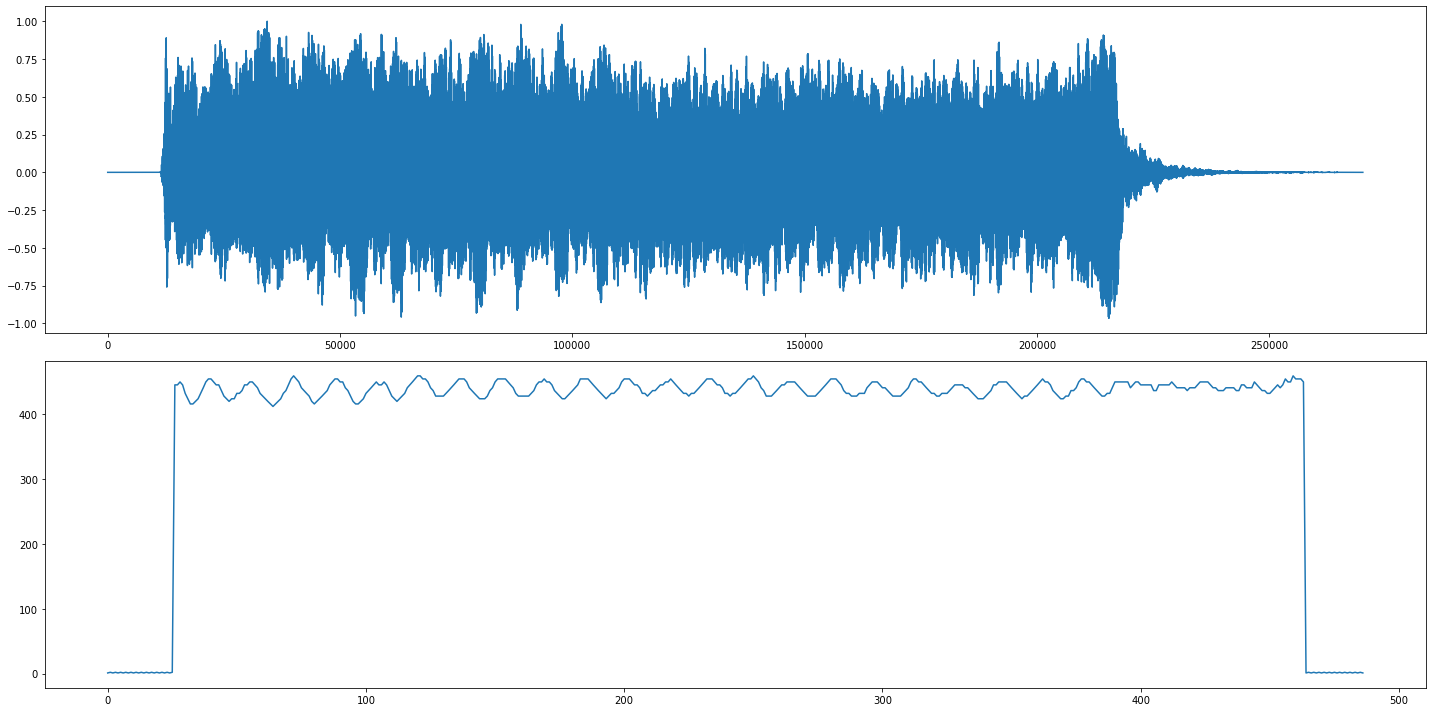

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# 246.9Hz violin audio

In [7]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/246.9Hz.wav")

Wall time: 185 ms


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_11136/1440229311.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(filename)


[]

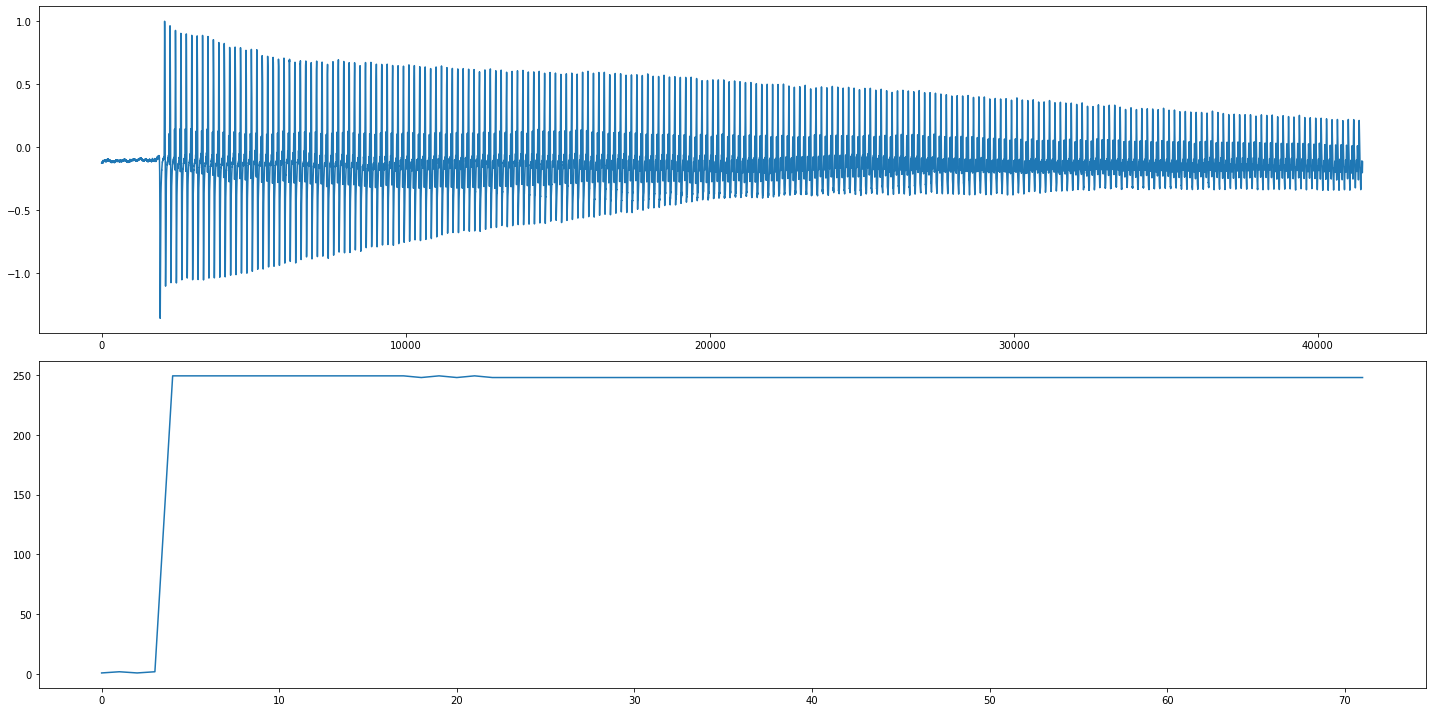

In [8]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# 300Hz audio

In [9]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/300Hz.wav")

Wall time: 1.69 s


[]

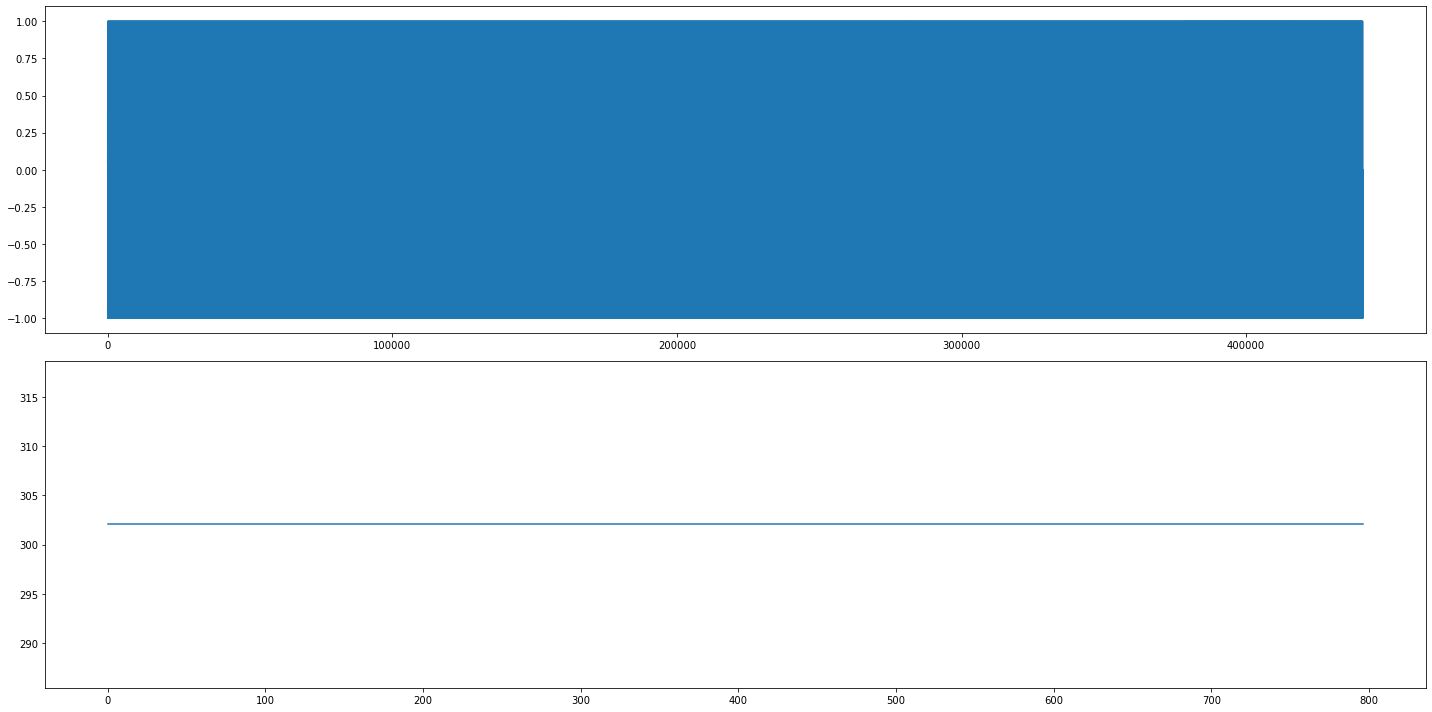

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Conversation audio

In [11]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/convesp.wav")

sendig posible value 235.8288770053476 Hz
sendig posible value 383.4782608695652 Hz
sendig posible value 273.9130434782609 Hz
sendig posible value 306.25 Hz
sendig posible value 390.2654867256637 Hz
sendig posible value 138.24451410658307 Hz
sendig posible value 134.4512195121951 Hz
sendig posible value 86.64047151277013 Hz
sendig posible value 80.18181818181819 Hz
sendig posible value 80.18181818181819 Hz
sendig posible value 80.18181818181819 Hz
sendig posible value 84.48275862068965 Hz
sendig posible value 88.73239436619718 Hz
sendig posible value 84.97109826589596 Hz
sendig posible value 84.64491362763916 Hz
sendig posible value 185.2941176470588 Hz
sendig posible value 168.3206106870229 Hz
sendig posible value 172.265625 Hz
sendig posible value 165.1685393258427 Hz
sendig posible value 165.1685393258427 Hz
sendig posible value 103.27868852459017 Hz
sendig posible value 512.7906976744187 Hz
sendig posible value 506.8965517241379 Hz
sendig posible value 189.27038626609442 Hz
sendig 

[]

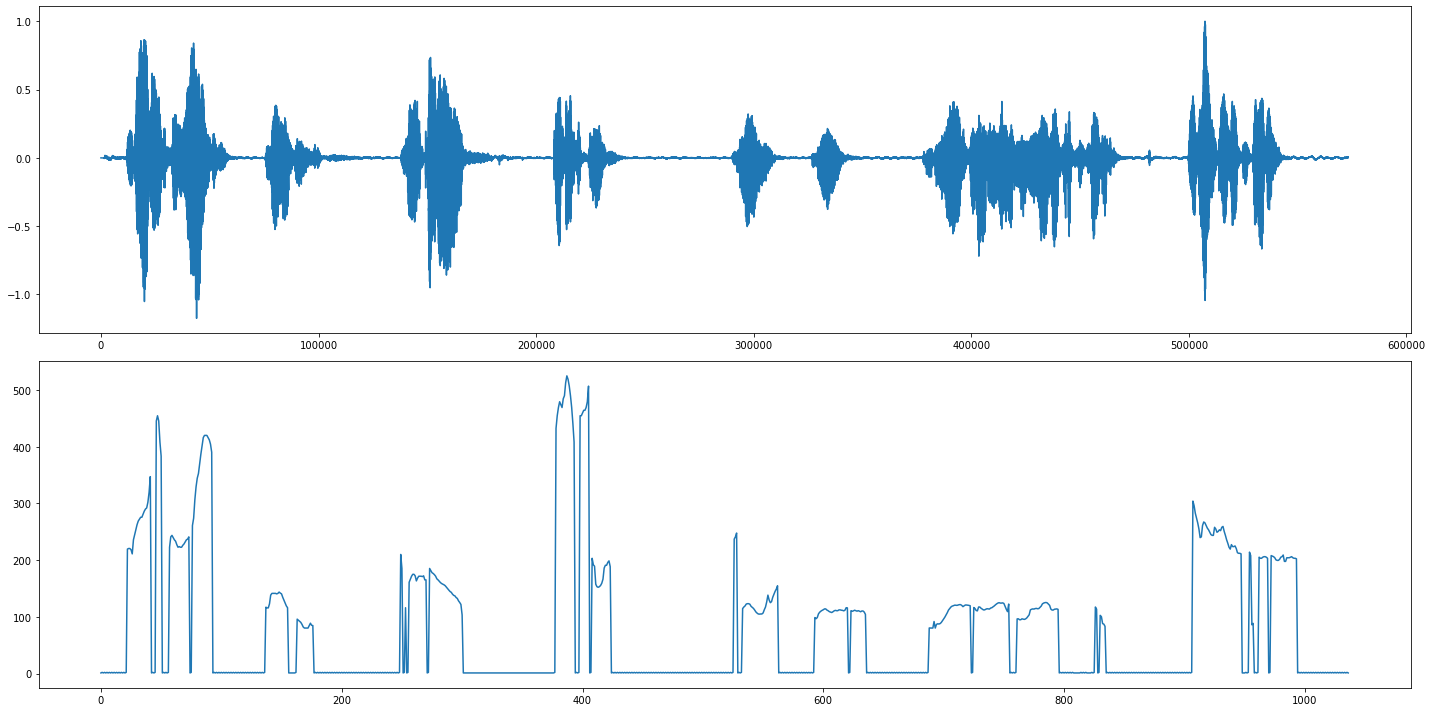

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Conversation 2 audio

In [13]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/conversation.wav")

sendig posible value 175.0 Hz
sendig posible value 89.27125506072875 Hz
sendig posible value 101.37931034482759 Hz
sendig posible value 81.97026022304833 Hz
sendig posible value 81.36531365313652 Hz
sendig posible value 82.58426966292134 Hz
sendig posible value 80.32786885245902 Hz
sendig posible value 80.18181818181819 Hz
sendig posible value 225.0 Hz
Wall time: 973 ms


[]

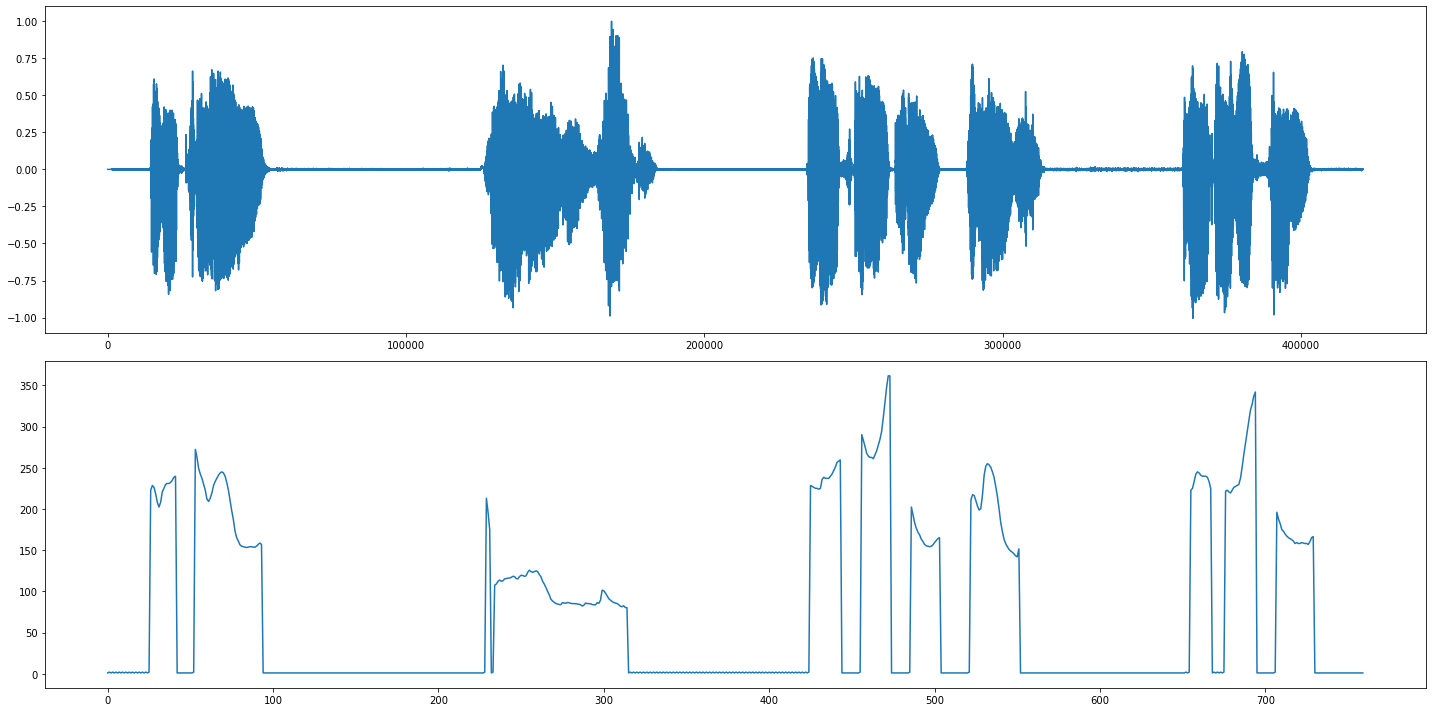

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()

# Test voices audio

In [15]:
%%time
audio, pitches, vals = fast_pitch_detection("assets/test_voice.wav")

sendig posible value 110.59907834101382 Hz
sendig posible value 116.2227602905569 Hz
sendig posible value 111.62790697674419 Hz
sendig posible value 118.51851851851852 Hz
sendig posible value 113.74407582938389 Hz
Wall time: 342 ms


[]

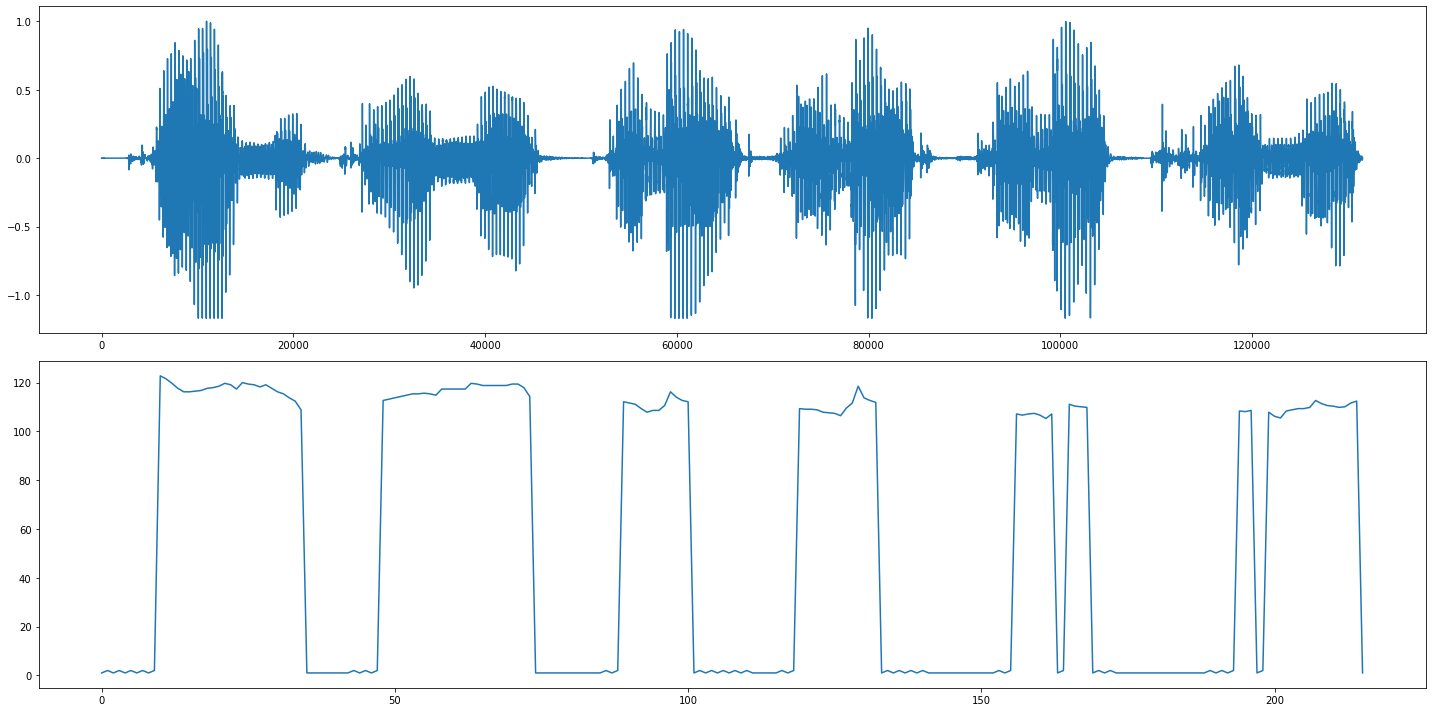

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(audio)
plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(pitches)
plt.tight_layout()
plt.plot()